In [20]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import pickle
import gzip

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score

from dadata import Dadata
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns


# делаем визуальную настройку графиков
sns.set_palette("Set2") 
sns.set_theme(style="whitegrid")


In [21]:
# Загрузка данных 
with gzip.open('data/cleaned_dataset.pkl.gz', 'rb') as f:
    data = pickle.load(f)

# Сбрасываем индекс
data = data.reset_index(drop=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542558 entries, 0 to 542557
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   regionName          542558 non-null  object
 1   minjustForm         542558 non-null  object
 2   minjustStatus       542558 non-null  object
 3   ogrn                542558 non-null  object
 4   is_liquidated       542558 non-null  int32 
 5   regionCode          542558 non-null  int32 
 6   hasRegionalSupport  542558 non-null  bool  
 7   opf.name            542558 non-null  object
 8   mainOkved.name      542558 non-null  object
 9   mainOkved.code      542558 non-null  object
 10  registration_year   542558 non-null  int32 
 11  liquidation_year    542558 non-null  int32 
 12  Contracts           542558 non-null  int32 
 13  Grants & Subsidies  542558 non-null  int32 
 14  years_income        542558 non-null  int32 
 15  is_new_okved        542558 non-null  int32 
 16  ad

# Анализ целевого признака

Для начала определимся, что будем считать целевым признаком:
- отдельно каждый из факта получения госконтракта/гранты и субсидии
- число различных видов госоддержки: варьируется в нашей задаче от 0 до 3
- факт получения какой либо господдержки

In [22]:
has_contracts = (data['Contracts'] > 0).astype(int)
has_grants = (data['Grants & Subsidies'] > 0).astype(int)

print(has_contracts.value_counts(normalize=True).round(3)*100)
print(' ')
print(has_grants.value_counts(normalize=True).round(3)*100)

data['support_count'] = data['Contracts'] + data['Grants & Subsidies']
print('''
Количество различных видов госоддержки, которые получила НКО'''
      )
data['support_count'].value_counts()

Contracts
0    95.8
1     4.2
Name: proportion, dtype: float64
 
Grants & Subsidies
0    97.6
1     2.4
Name: proportion, dtype: float64

Количество различных видов госоддержки, которые получила НКО


support_count
0    509254
1     30136
2      2843
3       325
Name: count, dtype: int64

Получаем сильный дисбаланс классов. 2 или более вида господдержки получили лишь 3168 НКО, что составляет всего 0.58 % от общего числа компаний или 9.5 % от числа НКО, которые получили хотя бы 1 вид господдержки. Российская система господдержки НКО имеет ярко выраженный порог доступа — большинство организаций либо не получают ничего, либо получают минимальную поддержку. Комплексное финансирование (2+ вида) — признак глубокой интеграции в систему, доступной менее чем 1% НКО.

В виду этого, а также поскольку бизнес-задача — определить факторы получения любой господдержки, а не её объёма или типа, мы создаём бинарный таргет has_support. Это даёт больше положительных примеров и позволит получить статистически значимые выводы о том, какие НКО вообще попадают в систему госфинансирования.

In [23]:
# Создаем признак таргет
data['has_support'] = ((data['Contracts'] > 0) | (data['Grants & Subsidies'] > 0)).astype(int)

print(data['has_support'].value_counts(normalize=True)*100) 

has_support
0    93.86167
1     6.13833
Name: proportion, dtype: float64


Раздельные таргеты дают более сильный дисбаланс:
- Контракты: 4.2% положительных
- Гранты и субсидии: 2.4% положительных

Объединённый таргет даёт на 50-150% больше положительных примеров для обучения модели. При дисбалансе >95:5 каждый дополнительный пример критически важен для качества модели.

In [24]:
# Удаляем Contracts, Grants & Subsidies
data.drop(['Contracts', 'Grants & Subsidies', 'support_count'], axis=1, inplace=True)

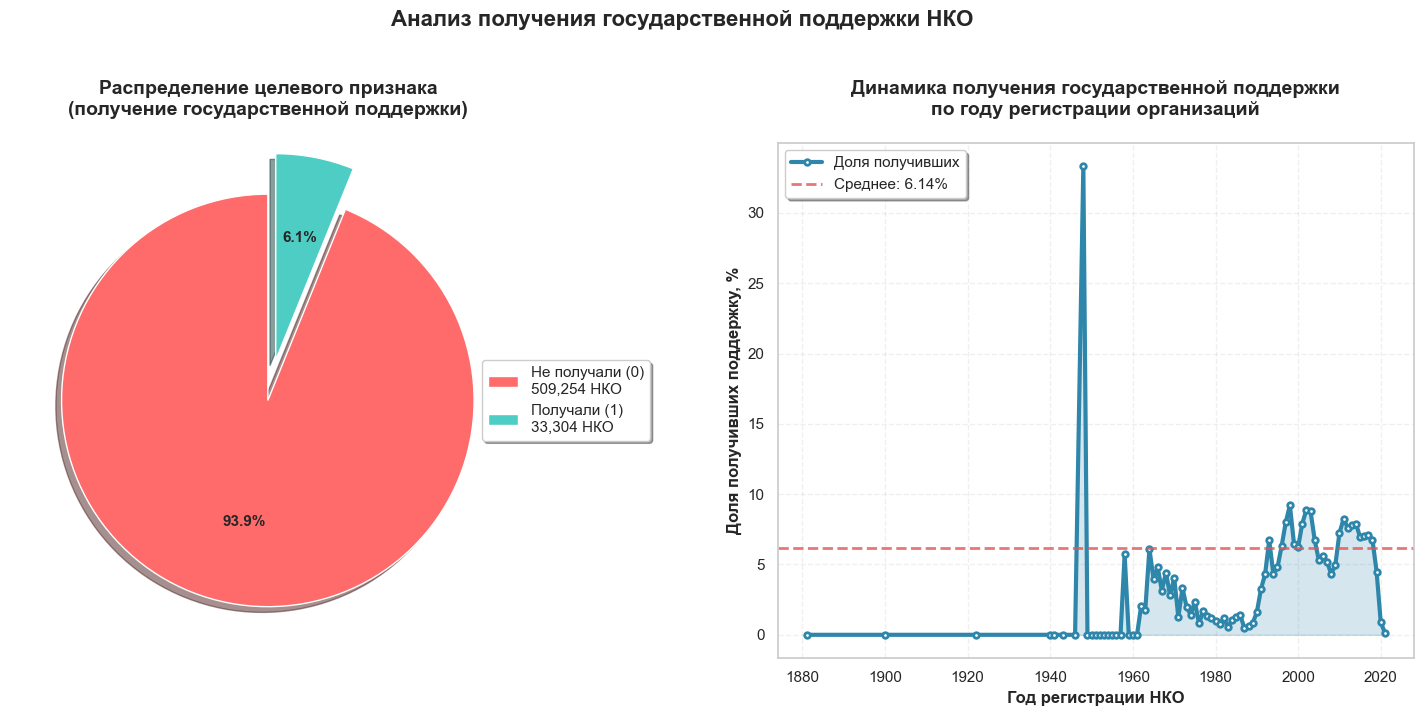

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
# Считаем распределение
target_counts = data['has_support'].value_counts()
target_percent = data['has_support'].value_counts(normalize=True) * 100

# Круговая диаграмма
ax[0].pie(
    target_counts.values,
    explode=(0, 0.2),
    colors=['#ff6b6b', '#4ecdc4'],
    autopct=lambda pct: f'{pct:.1f}%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Легенда
labels = [f'Не получали (0)\n{target_counts[0]:,} НКО', 
          f'Получали (1)\n{target_counts[1]:,} НКО']
ax[0].legend(labels, loc='center left', bbox_to_anchor=(0.9, 0.5), 
           fontsize=11, frameon=True, fancybox=True, shadow=True)

ax[0].set_title('Распределение целевого признака\n(получение государственной поддержки)', 
              fontsize=14, fontweight='bold', pad=20)

# Временной ряд получения поддержки по годам (группируем по году регистрации)

yearly_stats = data.groupby('registration_year')['has_support'].mean().round(4)*100

ax[1].plot(yearly_stats.index, yearly_stats.values, 
                color='#2E86AB', linewidth=3, marker='o', markersize=4,
                markerfacecolor='white', markeredgewidth=2, markeredgecolor='#2E86AB',
                label='Доля получивших')

# Область под кривой
ax[1].fill_between(yearly_stats.index, 0, yearly_stats.values, 
                 alpha=0.2, color='#2E86AB')

# Средняя линия
mean_support = data['has_support'].mean() * 100
ax[1].axhline(y=mean_support, color='#E15554', linestyle='--', linewidth=2, 
            alpha=0.8, label=f'Среднее: {mean_support:.2f}%')

# Настройки графика
ax[1].set_xlabel('Год регистрации НКО', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Доля получивших поддержку, %', fontsize=12, fontweight='bold')
ax[1].set_title('Динамика получения государственной поддержки\nпо году регистрации организаций', 
              fontsize=14, fontweight='bold', pad=20)

ax[1].grid(True, alpha=0.3, linestyle='--')
ax[1].legend(fontsize=11, loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.suptitle('Анализ получения государственной поддержки НКО', 
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()

In [26]:
# Узнаем в каком году был аномально высокий процент.;
yearly_stats.sort_values().tail(1)

registration_year
1948    33.33
Name: has_support, dtype: float64

Наблюдается выраженный дисбаланс классов: лишь 6% НКО получали государственную поддержку, тогда как 94% организаций не имели доступа к финансированию. Динамика по годам регистрации показывает общую стабильность — процент получающих поддержку колеблется в узком диапазоне 5-8% без заметного тренда на протяжении всего периода.

Однако выделяется явная аномалия в 1948 году, когда 33,3% зарегистрированных в тот год НКО получили господдержку — это в 5,5 раза выше среднегодового значения. Такое резкое отклонение может указывать на:

1. Особые исторические условия послевоенного периода
2. Целевые государственные программы поддержки НКО в тот год
3. Статистическую погрешность из-за малого количества НКО, зарегистрированных в 1948 году
4. Изменение правил регистрации или учёта организаций

Эта аномалия требует дополнительной проверки: возможно, речь идёт о небольшом количестве "долгоживущих" организаций советского периода, которые систематически получали поддержку, либо о специфике учётных данных для этого исторического периода.

Всего НКО зарегистрировано в 1948 году: 3
Из них получили господдержку: 1


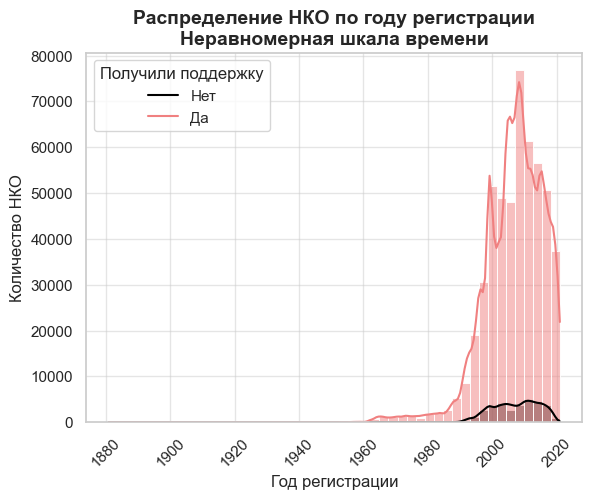

In [27]:
# Анализ аномалии 1948 года
nko_1948 = data.query('registration_year == 1948')
supported_1948 = nko_1948['has_support'].sum()

print(f"Всего НКО зарегистрировано в 1948 году: {nko_1948.shape[0]}")
print(f"Из них получили господдержку: {supported_1948}")

# Распределение НКО по годам регистрации
sns.histplot(data, x='registration_year',
             hue='has_support',
             bins=50,
             kde=True,
             palette={0: 'lightcoral', 1: 'black'});

plt.xticks(rotation=45)
plt.xlabel('Год регистрации', fontsize=12)
plt.ylabel('Количество НКО', fontsize=12)
plt.title('Распределение НКО по году регистрации\nНеравномерная шкала времени', 
          fontsize=14, fontweight='bold')
plt.legend(title='Получили поддержку', labels=['Нет', 'Да'])
plt.grid(alpha=0.5);

Аномалия 1948 года — это статистическая погрешность из-за малого количества наблюдений. Она не требует специального объяснения — это типичная проблема закона малых чисел. Как видно из графика, НКО, основанные раньше 1960 года, в целом составляют незначительную часть выборки, что подтверждает, что редкие исторические случаи не влияют на общие закономерности получения господдержки в современный период.

# Базовая модель

Сделаем *Baseline* модель и посчитаем метрики, которые она покажет. Их мы возьмем за основу, а также проверим удастся ли их улучшить существенным образом. Обычно в задачах классификации используют *accuracy, precision, recall* и *f1*. В качестве модели будем использовать одну из самых простых - логистическую регрессию.

*Accuracy* обычно используют только в сбалансированных выборках. Убедимся почему так происходит:

In [28]:
# Вместо предсказаний используем вектор-столбец, состоящий из нулей
y = data['has_support']
y_pred = np.zeros(len(y))

print(f'Метрика accuracy получилась равной {accuracy_score(y, y_pred):.2f}')

Метрика accuracy получилась равной 0.94


Модель вообще не находит получателей грантов, но accuracy = 0.94 — выглядит отлично, хотя на деле это бесполезная модель.Очевидно, что нужно опираться на другие метрики. Определимся какую лучше выбрать: *precision*  или *recall*.

- *Precision* (точность) показывает, какая доля объектов, предсказанных как положительные (получающие господдержку), действительно являются таковыми. Высокая *Precision* гарантирует, что среди отобранных НКО будет больше действительно подходящих кандидатов, но при этом модель может пропустить некоторые достойные организации. Данную метрику выбирают, если ключевое требование — минимизировать ошибки в отборе (например, из-за ограниченности ресурсов или высоких рисков)
- *Recall* (полнота) показывает, какая доля реальных положительных случаев (НКО, действительно получающих поддержку) была правильно предсказана моделью. Высокая *Recall* означает, что модель находит почти всех реальных получателей поддержки, но среди них может быть много ложных срабатываний. Данную метрику выбирают, если главное — не упустить ни одну достойную НКО, даже за счёт увеличения числа ложных срабатываний, приоритет — Recall.

Наша цель — дать НКО инструмент для понимания шансов на поддержку. Это значит:
- Пропуск «перспективных» НКО (FN) — критичная ошибка. Если модель скажет «шансов нет», а НКО могла бы получить грант — организация упустит возможность.
- Ложные срабатывания (FP) менее вредны. Если модель покажет «есть шансы», но НКО не получит грант, это не блокирует доступ к ресурсам — организация может попробовать ещё раз, доработать заявку и т. п.

Но если гнаться только за *Recall*, тогда модель может выдавать «есть шансы» почти всем НКО. Метрика *F1‑score* поможет найти баланс: он растёт, только если одновременно улучшаются и *Recall*, и *Precision*.

In [29]:
# # Удаляем текстовые столбцы, потому что модель на вход принимает только числа
X_data = data.select_dtypes(exclude=['object'])

# Смотрим какие признаки имеют очень сильную связь
X_data.corr()['has_support'].abs().sort_values(ascending=False)

has_support           1.000000
years_income          0.999999
hasRegionalSupport    0.212432
is_liquidated         0.136845
liquidation_year      0.135079
is_new_okved          0.121295
regionCode            0.026489
registration_year     0.008871
Name: has_support, dtype: float64

У признака *years_income* слишком сильная связь с таргетом. Его стоит удалить перед обучением модели, чтобы не было утечки данных

In [100]:
# Удаляем has_support и years_income
X = X_data.drop(['has_support', 'years_income'], axis=1)
y = data['has_support']

# Разбиваем выборки на тренировочную и тестовую:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [101]:
baseline = LogisticRegression(random_state=1)

# Обучаем модель и делаем предстазание
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

# Вычисляем метрики
print(f'accuracy_score: {accuracy_score(y_test, y_pred):.4f}')
print(f'recall_score : {recall_score(y_test, y_pred):.4f}')
print(f'f1_score:  {f1_score(y_test, y_pred):.4f}')

accuracy_score: 0.9384
recall_score : 0.0036
f1_score:  0.0071


На основании приведённых метрик о базовой модели можно сделать однозначный вывод: модель крайне неэффективна для задачи выявления положительного класса. Несмотря на высокий accuracy модель не справилась с дисбалансов классов.

# Анализ признаков (фичей)

In [32]:
# Будем работать с копией датасета
df = data.copy()

ОГРН не будем рассматривать в анализе, он служит лишь для идентификации организации. Впоследствие он будет удален.

In [33]:
# Группируем признаки по типам

categorical_features = [
    'minjustForm',
    'minjustStatus',
    'opf.name',
    'mainOkved.name',
    'admin_group', 
    'regionName'
]

# Делайем hasRegionalSupport числовым
df['hasRegionalSupport'] = df['hasRegionalSupport'].astype(int)

numeric_features = [
    'years_income',     
    'registration_year',
    'liquidation_year',
    'is_liquidated',
    'hasRegionalSupport',
    'is_new_okved',
    'regionCode'
]


### Категориальные признаки

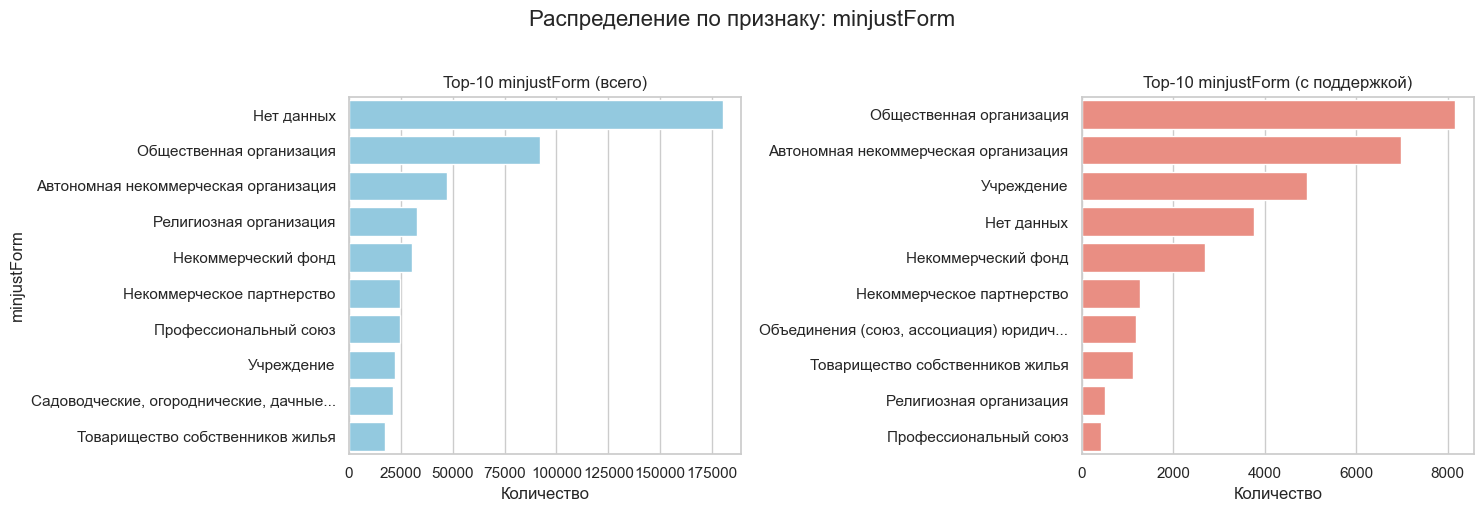

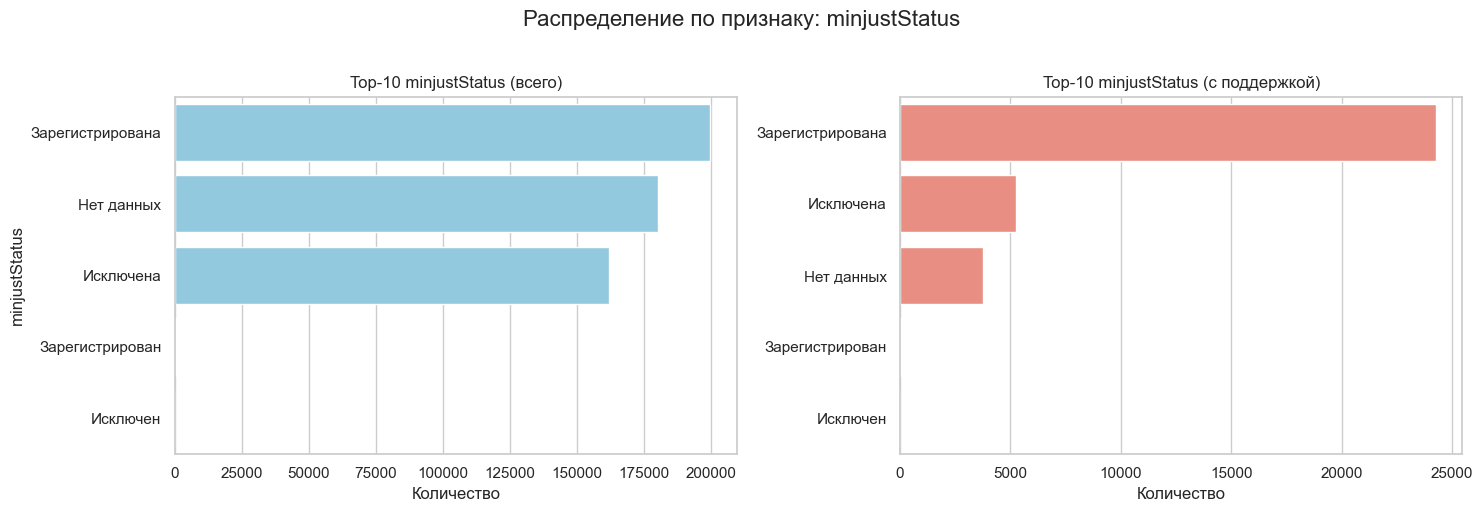

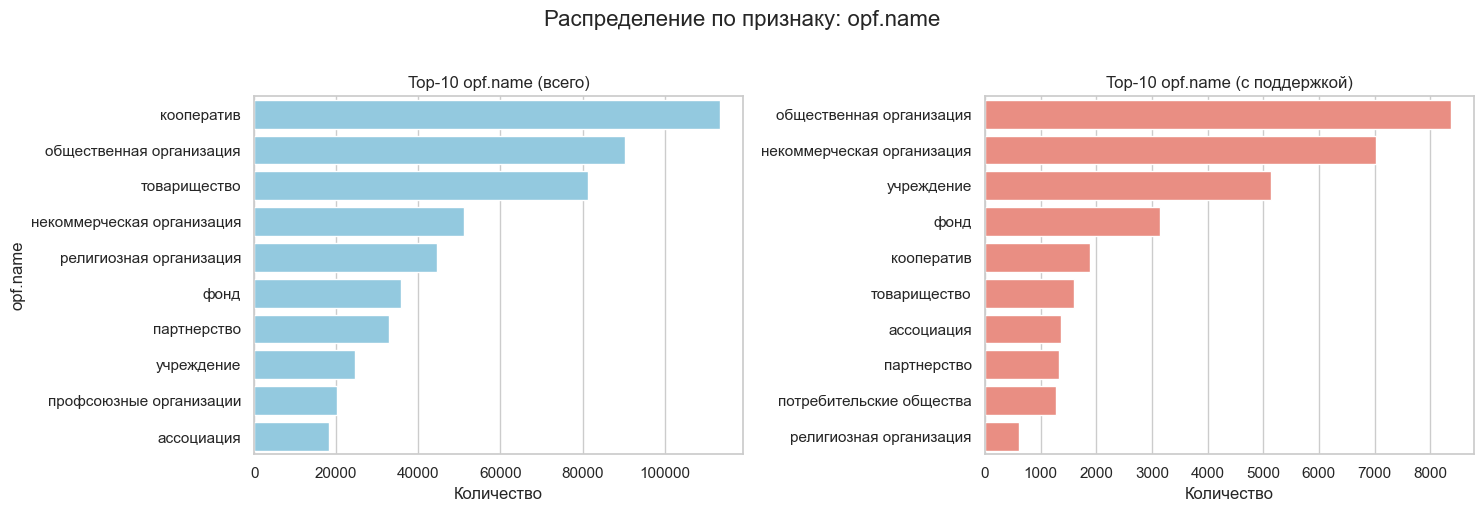

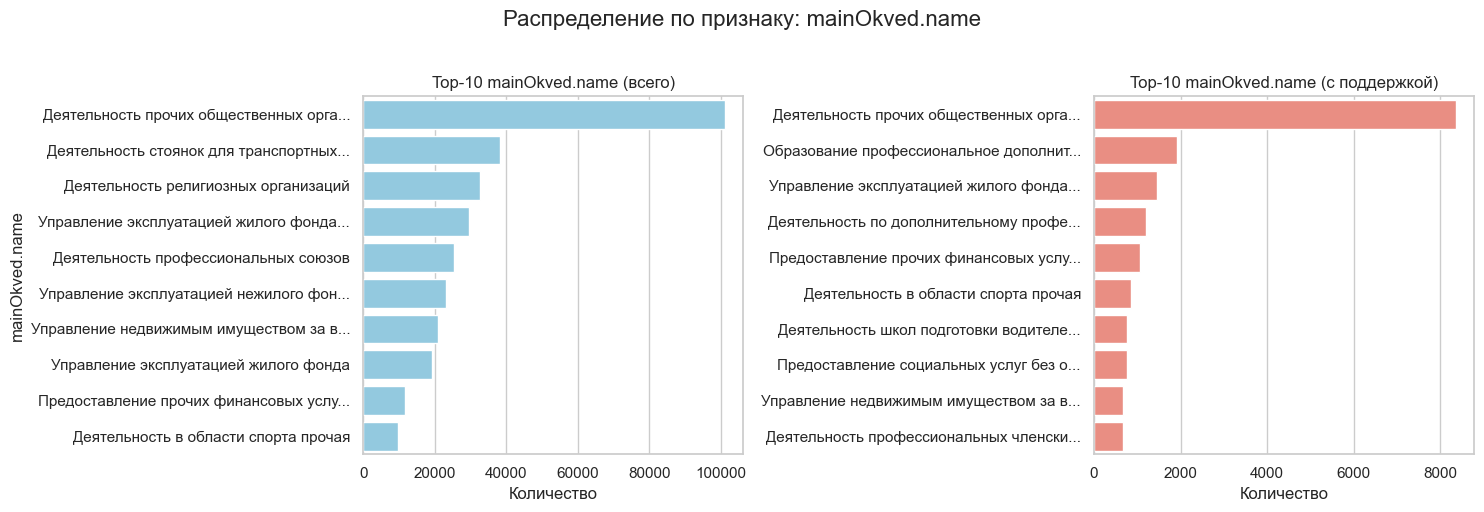

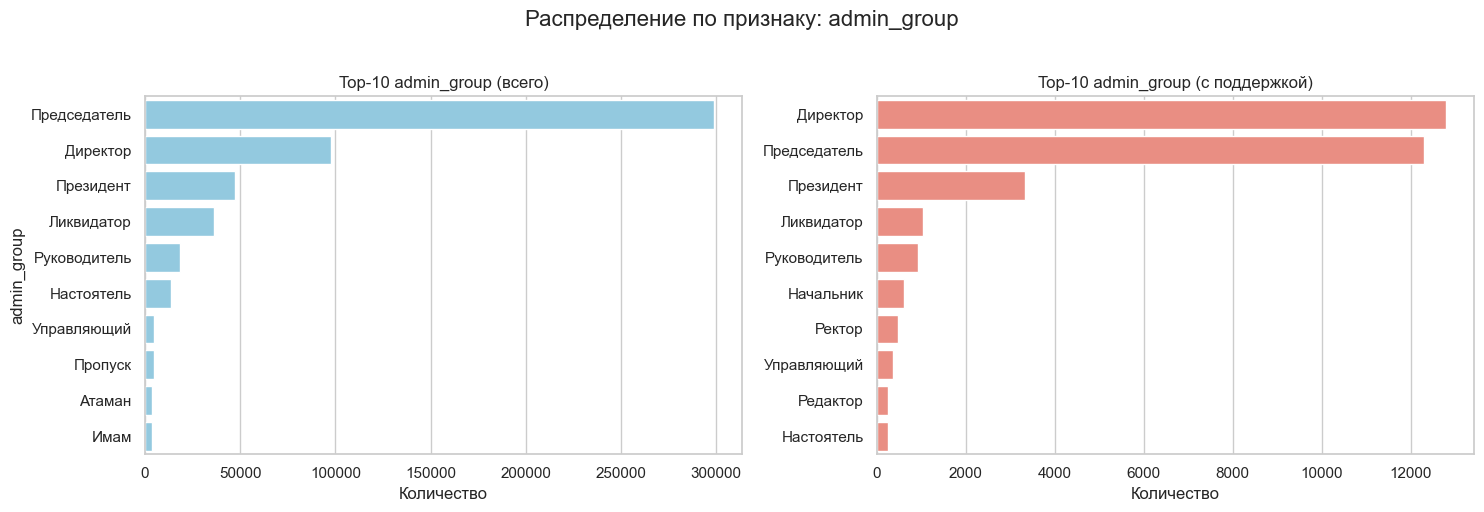

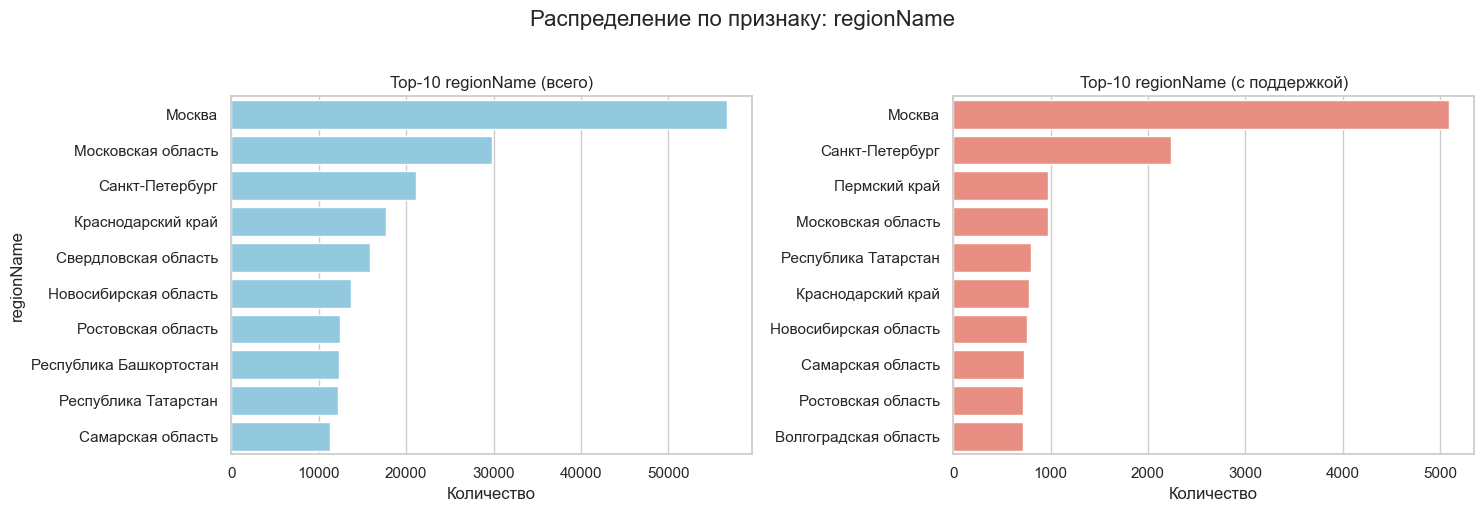

In [34]:
# Будем использовать эту функцию для ограничения длины наименований
def truncate_label(label: str, max_length: int) -> str:
    """Обрезает метку до заданной длины, добавляя многоточие."""
    if len(label) <= max_length:
        return label
    return label[:max_length-3] + '...'


def plot_top10_categorical(df, feature: str, categorical_features: list):
    """Строит сравнительные графики Top-10 для категориального признака."""
    # Подсчет топ-10 для всех записей и записей с поддержкой
    top10_all = (df[feature]
                .value_counts()
                .nlargest(10)
                .reset_index(name='count'))
    
    top10_supported = (df.query('has_support == 1')[feature]
                      .value_counts()
                      .nlargest(10)
                      .reset_index(name='count'))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График 1: все записи
    sns.barplot(data=top10_all, x='count', y=feature, ax=ax1, color='skyblue')
    ax1.set_title(f'Top-10 {feature} (всего)')
    ax1.set_xlabel('Количество')
    ax1.set_ylabel(feature)
    
    # Обрезаем метки
    labels1 = [item.get_text() for item in ax1.get_yticklabels()]
    short_labels1 = [truncate_label(label, 40) for label in labels1]
    ax1.set_yticklabels(short_labels1)

    # График 2: записи с поддержкой
    sns.barplot(data=top10_supported, x='count', y=feature, ax=ax2, color='salmon')
    ax2.set_title(f'Top-10 {feature} (с поддержкой)')
    ax2.set_xlabel('Количество')
    ax2.set_ylabel('')
    
    # Обрезаем метки
    labels2 = [item.get_text() for item in ax2.get_yticklabels()]
    short_labels2 = [truncate_label(label, 40) for label in labels2]
    ax2.set_yticklabels(short_labels2)

    fig.suptitle(f'Распределение по признаку: {feature}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


# Основной цикл
for feature in categorical_features:
    plot_top10_categorical(df, feature, categorical_features)


На основе анализа распределения семи признаков среди всех организаций и организаций, получивших господдержку, можно сделать следующие выводы о синергии каждого признака с целевой переменной:

***Признаки с выраженной положительной корреляцией:***
*
1. Основной вид деятельности *(mainOkved.name)*
Наиболее значимый предиктор. Наблюдается кардинальное изменение в топ-10 видов деятельности у организаций с поддержкой — происходит явный сдвиг от операционно-хозяйственной деятельности к социально-образовательной и общественно-полезной.

2. Организационно-правовая форма *(OPF.name)* и форма по Минюсту *(minjustForm)*
Оба признака демонстрируют схожую закономерность: юридически оформленные некоммерческие структуры (общественные организации, автономные НКО) существенно чаще получают поддержку по сравнению с организациями без четкого правового статуса.

3. Код ОКВЭД *(mainOkved.code)*
Коды, связанные с общественной деятельностью и образованием, явно преобладают среди получателей поддержки, что подтверждает тренд, выявленный по наименованиям видов деятельности.

***Признак со средней корреляцией:***

4. Должность руководителя *(admin_group)*
Наблюдается определенная связь: среди получателей поддержки чаще встречаются организации с традиционными управленческими должностями и появляются специфические "образовательные" позиции (ректоры, начальники), что указывает на некоторое влияние профессионального менеджмента.

***Признаки со слабой или отсутствующей корреляцией:***

5. Географический признак *(regionName)*
Распределение по регионам практически не меняется — столичные и крупные регионы лидируют как в общем списке, так и среди получателей поддержки. География не является дифференцирующим фактором.

6. Статус в Минюсте *(minjustStatus)*
Статус регистрации практически не коррелирует с получением поддержки. Организации с разными статусами, включая "исключенные", присутствуют в обоих распределениях в схожих пропорциях.

**Ключевая закономерность:**

Система господдержки демонстрирует содержательно-целевую селективность, а не формально-административную. Решающее значение имеют:
- Содержание деятельности (социальная, образовательная, общественная направленность)
- Юридическая определенность (оформленный статус НКО)

При этом практически не учитываются:

- Географическое положение
- Текущий формальный статус регистрации

Фактический механизм отбора: поддержку получают в первую очередь юридически оформленные организации, ведущие социально-значимую деятельность, независимо от их местоположения и текущих административных статусов.

### Числовые признаки

In [35]:
# Преобразуем фичу minjustStatus с помощью порядкового кодирования

status_mapping = {
    'Зарегистрирован': 2,
    'Зарегистрирована': 2,
    'Исключен': 1,  
    'Исключена': 1,     
    'Нет данных': 0 
}

df['minjustStatus'] = df['minjustStatus'].map(status_mapping)

# Добавим minjustStatus в numeric_features
numeric_features.append('minjustStatus')

df['minjustStatus'].value_counts()

minjustStatus
2    200338
0    180153
1    162067
Name: count, dtype: int64

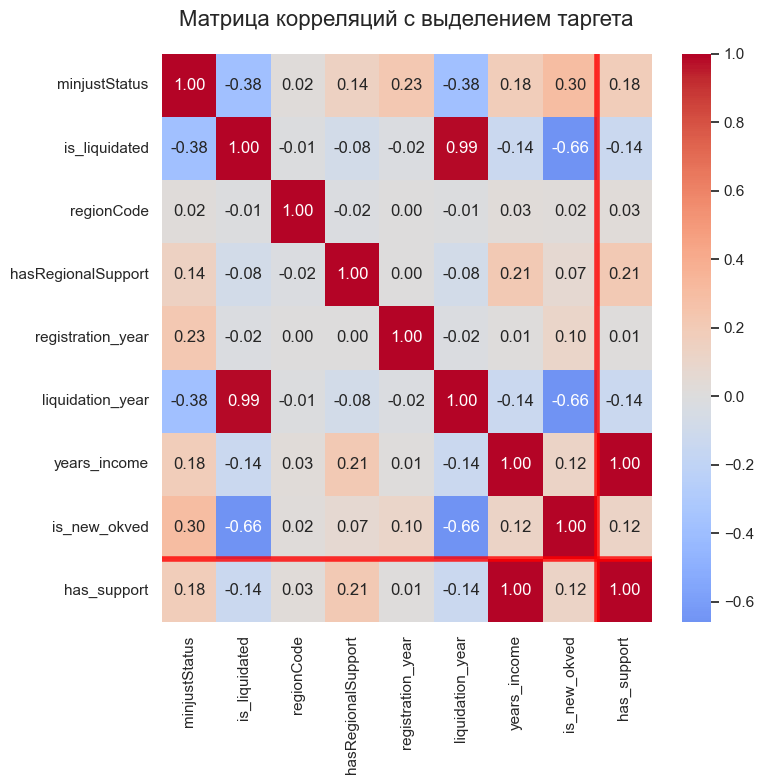

In [36]:
corr_matrix = df.corr(numeric_only=True)

target_col = 'has_support'

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0, ax=ax)

# Красные линии точно по центру строки/столбца таргета
target_idx = corr_matrix.index.get_loc(target_col)
ax.axhline(y=target_idx, color='red', linewidth=4, alpha=0.8)
ax.axvline(x=target_idx, color='red', linewidth=4, alpha=0.8)

plt.title('Матрица корреляций с выделением таргета', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


**Полная линейная зависимость с таргетом**: *years_incom*e — корреляция 1.00

**Сильная мультиколлинеарность**: *is_liquidated* ↔ *liquidation_year* — корреляция 0.99


**Средняя значимость:**
- *hasRegionalSupport* — корреляция 0.21
- *minjustStatus* — корреляция 0.18

**Слабая значимость:**
- *is_new_okved* — корреляция 0.12
- *is_liquidated* — корреляция -0.14

**Минимальная значимость:**
- regionCode — корреляция 0.03
- registration_year — корреляция 0.01

***Ключевые инсайты:***
- Признак *years_income* — либо утечка данных, либо прямой показатель поддержки
- Региональная поддержка (*hasRegionalSupport*) — лучший предиктор федеральной поддержки
- Юридический статус (*minjustStatus*) — имеет значение, но не является барьером получения господдержки

***Отсутствующие зависимости:***
- География — код региона не влияет на получение поддержки
- Год регистрации не коррелирует с поддержкой
- Статус исключения — не блокирует получение поддержки

***Итоговая картина:***
Система поддержки демонстрирует содержательную селективность (предыдущий опыт поддержки, юридический статус) при отсутствии формальных барьеров (география, возраст организации, текущий статус регистрации). Это свидетельствует о достаточно объективной системе распределения поддержки.

# Анализ взаимосвязей между признаками

**Проведем анализа кросс-таблиц категориальных признаков:**

#### **1. Регион × ОПФ**

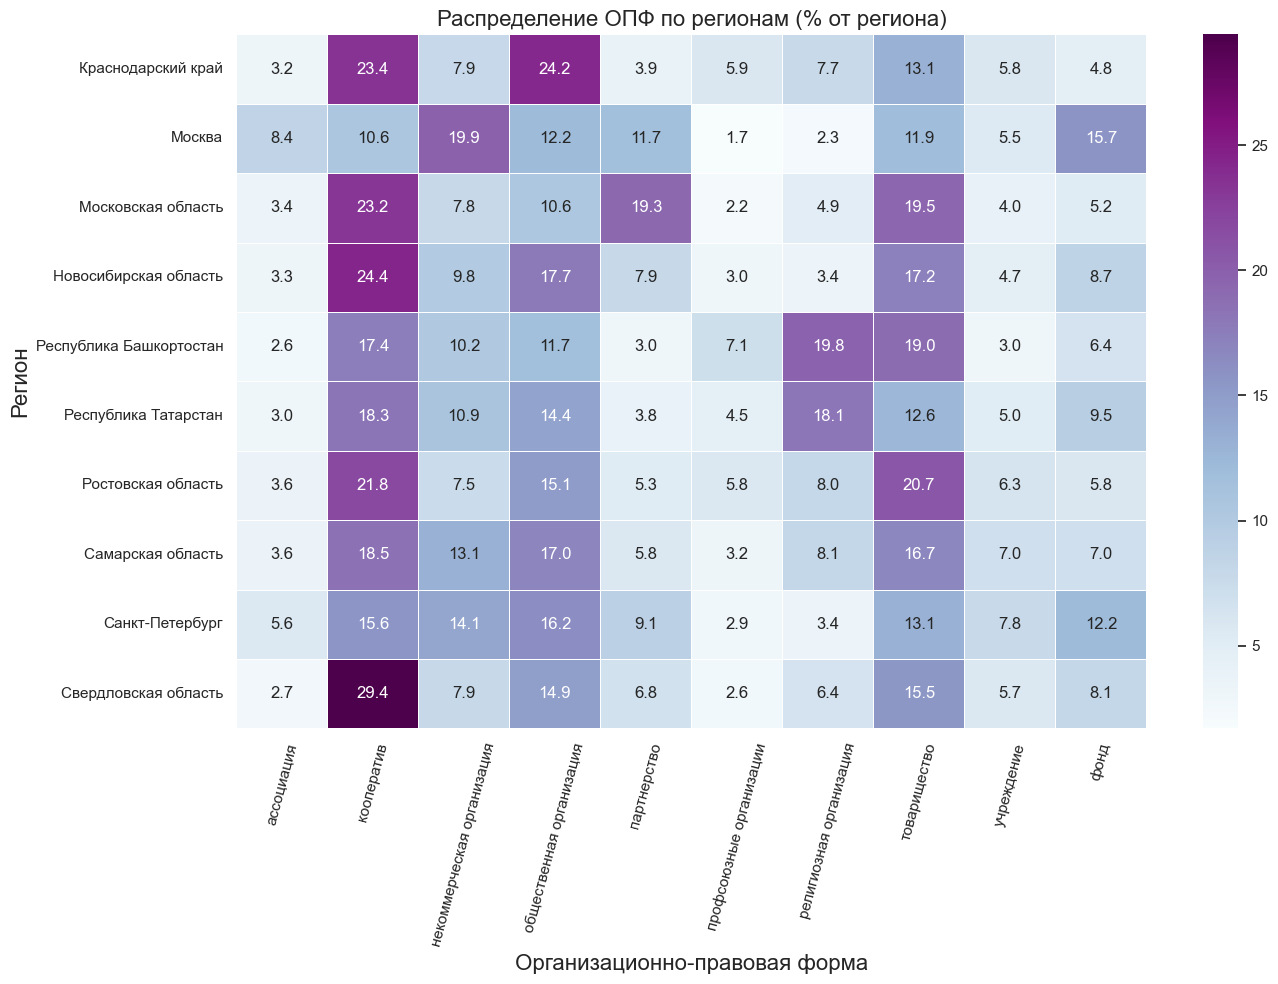

In [37]:
# Создаем кросс-таблицу для топ-10 регионов и топ-10 ОПФ
top_regions = df['regionName'].value_counts().head(10).index
top_opf = df['opf.name'].value_counts().head(10).index

# Фильтруем данные
df_filtered = df[df['regionName'].isin(top_regions) & df['opf.name'].isin(top_opf)]

# Создаем кросс-таблицу с процентами по строкам
cross_table_percent = pd.crosstab(df_filtered['regionName'], 
                                  df_filtered['opf.name'], 
                                  normalize='index') * 100

# Heatmap с процентами
plt.figure(figsize=(14, 10))
sns.heatmap(cross_table_percent, 
            annot=True, 
            fmt='.1f',
            cmap='BuPu',
            linewidths=0.5)

plt.title('Распределение ОПФ по регионам (% от региона)', fontsize=16)
plt.xlabel('Организационно-правовая форма', fontsize=16)
plt.ylabel('Регион', fontsize=16)
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

- Региональная специфика ОПФ ярко выражена: столицы предпочитают учреждения и классические НКО, регионы — жилищные объединения и кооперативы. Это отражает разные экономические и социальные условия.
- Татарстан, Москва, МО, Свердловская область — регионы с наиболее развитой системой господдержки НКО среди крупнейших субъектов РФ.
- Санкт-Петербург, несмотря на статус города федерального значения и большое количество НКО, проигрывает другим ведущим регионам по доступности господдержки для НКО. Возможная причина: в Санкт-Петербурге может быть больше НКО, но меньше процент тех, кто получает господдержку, либо конкуренция выше, либо механизмы поддержки менее доступны.
- Доступность господдержки куда больше зависит от формы НКО, нежели от принадлежности к какому-то региону



#### **2. Регион × Статус Минюста**

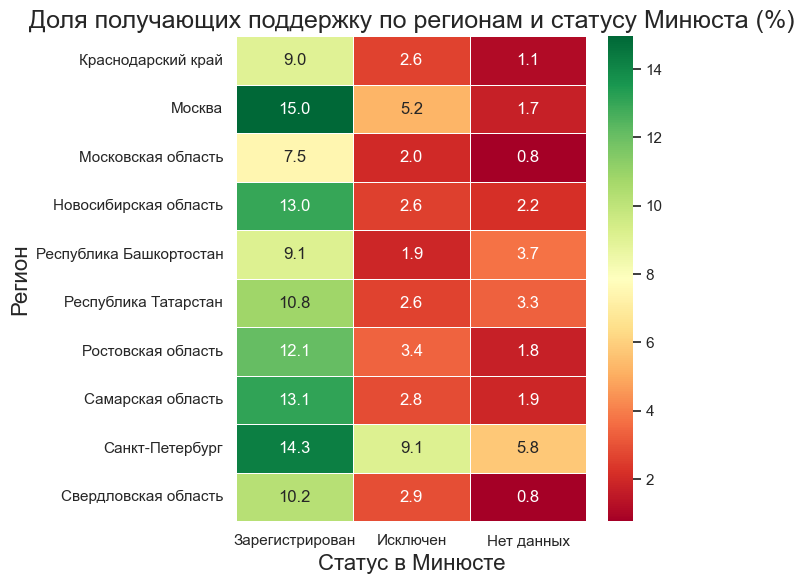

In [38]:
# Создаем кросс-таблицу для топ-10 регионов и статусов Минюста
top_regions = df['regionName'].value_counts().head(10).index

status_order = {
    2: 'Зарегистрирован',
    1: 'Исключен',  
    0: 'Нет данных'
}

df_filtered = df[df['regionName'].isin(top_regions)]

# Кросс-таблица с поддержкой (доля получающих поддержку)
cross_table_support = pd.crosstab(df_filtered['regionName'], 
                                  df_filtered['minjustStatus'].map(status_order),
                                  values=df_filtered['has_support'],
                                  aggfunc='mean') * 100

# Визуализация
plt.figure(figsize=(7, 6))
sns.heatmap(cross_table_support, 
            annot=True, 
            fmt='.1f',
            cmap='RdYlGn',
            linewidths=0.5)
plt.title('Доля получающих поддержку по регионам и статусу Минюста (%)', fontsize=18)
plt.xlabel('Статус в Минюсте', fontsize=16)
plt.ylabel('Регион', fontsize=16)
plt.tight_layout()
plt.show()

- *Санкт-Петербург:* Максимум "неопределенных" статусов ("Нет данных" (5.8%) + "Исключен" (9.1%) = 14.9%)

- *Москва:* Максимум "Зарегистрирован" (15.0%), минимум проблемных статусов

- *Татарстан/Башкортостан:* Выше среднего по "Исключен" (активная ротация НКО)

Санкт-Петербург требует отдельного аудита данных — либо проблемы с регистрацией НКО, либо особенности ведения реестра. Москва — самая "аккуратная" по юридическому статусу.

Итог: Юридическая "культура" НКО различается по регионам: от образцового порядка в Москве до хаотичной ротации в Татарстане и проблем с данными в Петербурге. В целом уровень господдержки куда больше зависит от статуса в Минюсте, нежели от региона.
.

#### **3. Статус × Форма НКО (minjustStatus × minjustForm)**

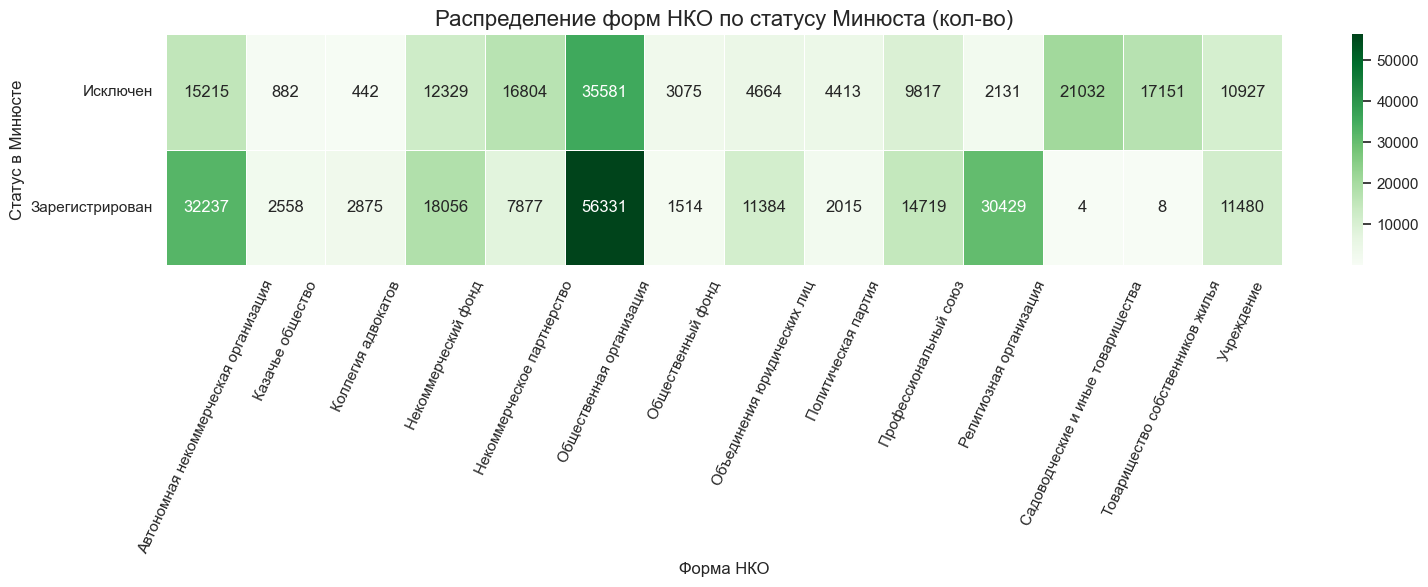

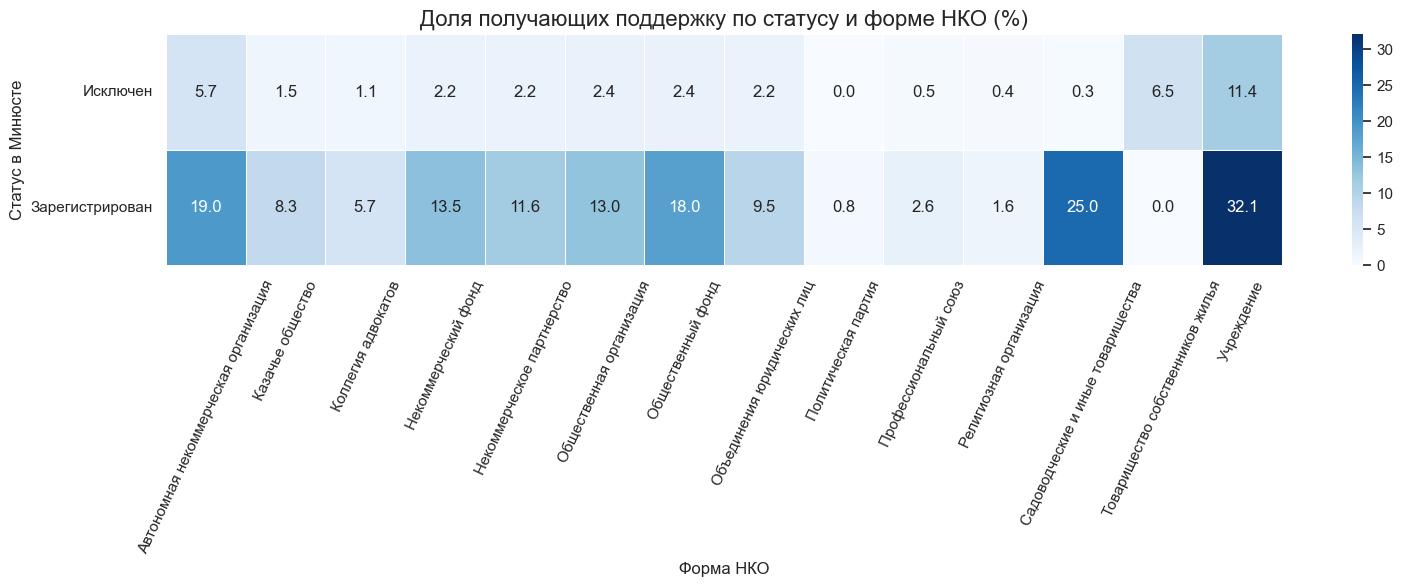

In [39]:
# Берем топ-10 форм НКО
top_forms = df['minjustForm'].value_counts().head(15).index

df_filtered = df[(df['minjustStatus'] > 0) & (df['minjustForm'].isin(top_forms))]

df_filtered['minjustForm'] = df_filtered['minjustForm'].replace({
    'Садоводческие, огороднические, дачные и иные некоммерческие товарищества':
        'Садоводческие и иные товарищества',
    'Объединения (союз, ассоциация) юридических лиц': 'Объединения юридических лиц'
})

# Кросс-таблица с абсолютными значениями
cross_table_counts = pd.crosstab(df_filtered['minjustStatus'], 
                                 df_filtered['minjustForm'])

# Кросс-таблица с поддержкой
cross_table_support = pd.crosstab(df_filtered['minjustStatus'], 
                                  df_filtered['minjustForm'],
                                  values=df_filtered['has_support'],
                                  aggfunc='mean') * 100

# Визуализация абсолютных значений
plt.figure(figsize=(18, 3))
sns.heatmap(cross_table_counts, 
            annot=True, 
            fmt='d',
            cmap='Greens',
            linewidths=0.5)

plt.title('Распределение форм НКО по статусу Минюста (кол-во)', fontsize=16)
plt.xlabel('Форма НКО', fontsize=12)
plt.ylabel('Статус в Минюсте', fontsize=12)
plt.tight_layout()
plt.xticks(rotation=65)
plt.yticks(ticks=[0.5, 1.5], labels=['Исключен', 'Зарегистрирован'], rotation=0)
plt.show()

# Визуализация доли поддержки
plt.figure(figsize=(18, 3))
sns.heatmap(cross_table_support, 
            annot=True, 
            fmt='.1f',
            cmap='Blues',
            linewidths=0.5)
plt.title('Доля получающих поддержку по статусу и форме НКО (%)', fontsize=16)
plt.xlabel('Форма НКО', fontsize=12)
plt.ylabel('Статус в Минюсте', fontsize=12)
plt.tight_layout()
plt.xticks(rotation=65)
plt.yticks(ticks=[0.5, 1.5], labels=['Исключен', 'Зарегистрирован'], rotation=0)
plt.show()

<u> Разные формы НКО имеют разную культуру регистрации:</u>

- Общественные организации, ТСЖ, Учреждения — активно регистрируются и поддерживают статус
- Религиозные организации — практически игнорируют официальную регистрацию
- Автономные НКО и партнерства — средний уровень формализации

Система регистрации работает избирательно: некоторые формы НКО системно избегают или не проходят регистрацию в Минюсте, что требует отдельного аудита и возможно, упрощения процедур.

<u> Доля поддержки по статусу и форме НКО:</u>


Система господдержки справедливо дискриминирует по юридическому статусу:

- Зарегистрированные НКО получают существенно больше 
- Исключенные НКО всё же имеют шанс (особенно учреждения — 11.4%), это скорее иключение
- Некоторые формы (религиозные, садоводческие) слабо вовлечены в систему поддержки

Система работает логично: активный юридический статус — важный, но не единственный критерий. Учреждения сохраняют доступ к поддержке даже после исключения, что может указывать на их особый статус. Вероятно это связано с тем, что они часто государственные/муниципальные.


# Статистические тесты

In [40]:
# Возьмем стандарный уровень значимости
alpha = 0.05 

# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    
    print(f'  p-value = {p:.3f}')
    
    if p <= alpha:
        print(f'''p-значение меньше, чем заданный уровень значимости {alpha}.
Отвергаем нулевую гипотезу в пользу альтернативной.''')
        
    else:
        print(''' p-значение больше, чем заданный уровень значимости {alpha}.
У нас нет оснований отвергнуть нулевую гипотезу.''')

Из признаков даты ликвидации *(liquidation_year)* и даты регистрации *(registration_year)* получим более удобный - возраст организации. Он будет считаться как разница между годом регистрации и текущим годом (для активных организаций) или годом ликвидации (для ликвидированных НКО). За текущий год возьмем год выгрузки дампов данных - 2021.

В датасете есть организации, которые считаются ликвидированными, но у них не указан год ликвидации. То есть вместо года стоит 0. По нашей формуле мы получим отрицательный возраст. С помощью API-сервиса вычислим, действительно ли такие НКО являются ликвидированными, и если да, то выгрузим год ликвидации.

In [41]:
# API ключ DaData
token = "846481f414a88539d327646bac9632856ed73f39"
dadata = Dadata(token)
i = 0

# НКО с конфликтом: liquidation_year=0 но is_liquidated=1
conflicting_ogrns = df[(df['liquidation_year'] == 0) & (df['is_liquidated'] == 1)]['ogrn']
print(f"Конфликтующих НКО: {len(conflicting_ogrns)}")

for ogrn in conflicting_ogrns:
    # Получаем актуальные данные через DaData
    result = dadata.suggest("party", ogrn)
    unix_date = result[0]['data']['state']['liquidation_date']
    
    if unix_date:
        # Переводим дату из Unix timestamp (в миллисекундах) к годам
        liq_year = pd.to_datetime(unix_date, unit='ms').year
        
        # Текущая дата для нас - конец 2021 года
        if liq_year <= 2021:
            df.loc[df['ogrn'] == ogrn, 'liquidation_year'] = liq_year
            i += 1
            
        else:
            # Ликвидация после дампа → НКО активна на 2021
            df.loc[df['ogrn'] == ogrn, 'is_liquidated'] = 0
    else:
        # Нет даты ликвидации → НКО активна
        df.loc[df['ogrn'] == ogrn, 'is_liquidated'] = 0
        
print(f'С помощью API-сервиса Dadata были заполнены {i} годов  строк в датасете')
print(f'А {len(conflicting_ogrns) - i} НКО на самом деле оказались действующими')

Конфликтующих НКО: 3488
С помощью API-сервиса Dadata были заполнены 2778 годов  строк в датасете
А 710 НКО на самом деле оказались действующими


С конфиктующими данными разобрались, теперь можно вычислить возраст каждой НКО.

In [42]:
# Напишем функцию, считающую возраст НКО
def age_calculate(df):
    """Рассчитывает возраст НКО на 2021: до ликвидации или текущий."""
    
    if df['is_liquidated'] == 0:
        age = 2021 - df['registration_year']
        
    else:
        age = df['liquidation_year'] - df['registration_year']
        
    return age

# Посчитаем возраст каждой НКО
df['age'] = df.apply(age_calculate, axis=1)

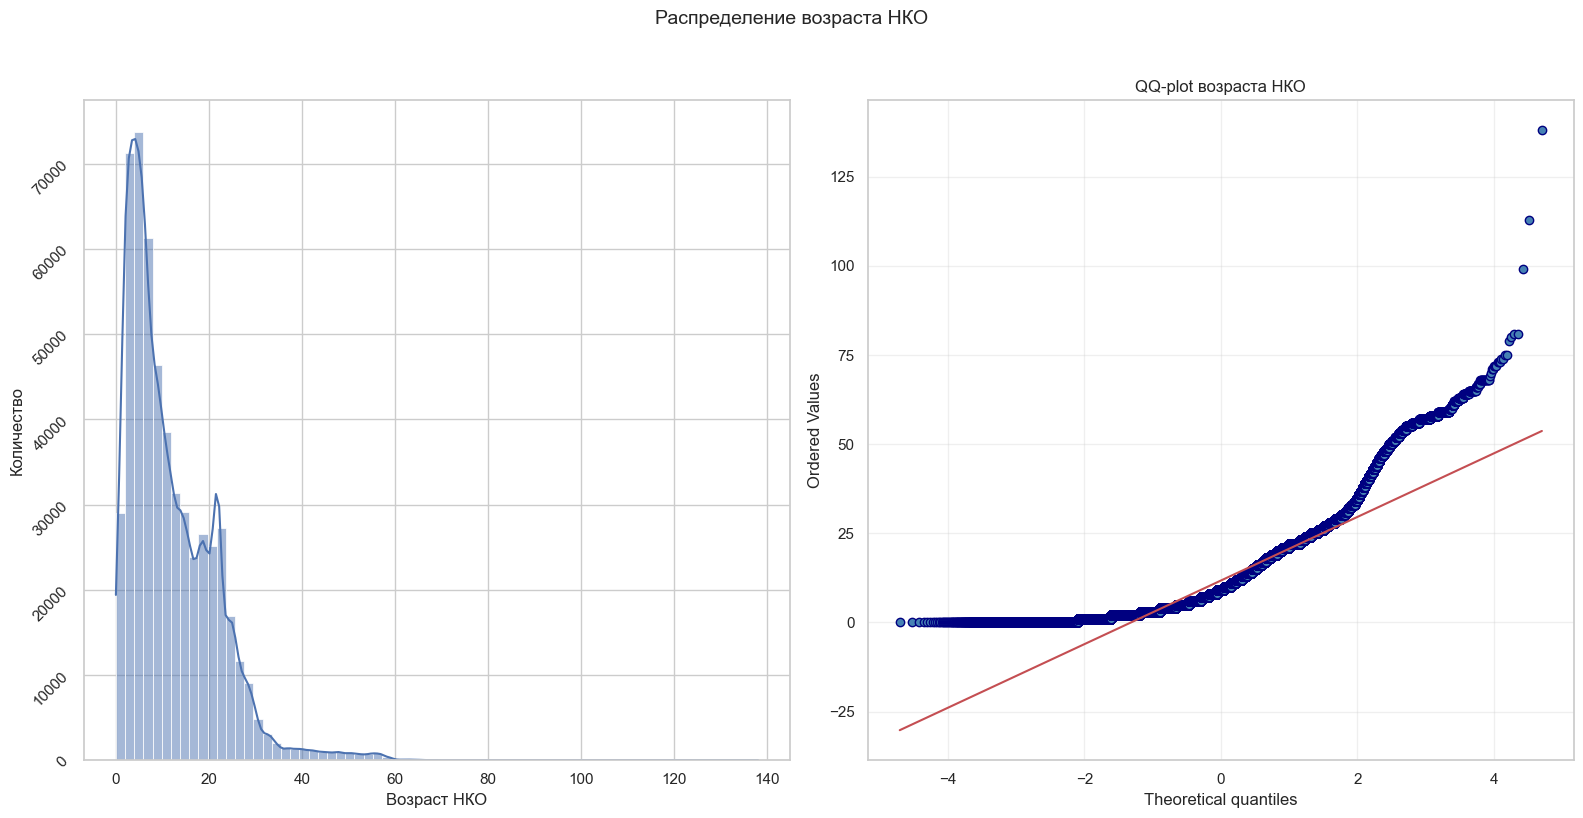

In [43]:
# Посмотрим на распределение возраста НКО:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ГИСТОГРАММА
sns.histplot(data=df, x='age', kde=True, bins=70, ax=ax1)
ax1.set_xlabel('Возраст НКО', fontsize=12)
ax1.set_ylabel('Количество', fontsize=12)
ax1.tick_params(axis='y', rotation=45)

# QQ-PLOT
stats.probplot(df['age'].dropna(), dist="norm", plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('steelblue')
ax2.get_lines()[0].set_markeredgecolor('navy')
ax2.grid(True, alpha=0.3)
ax2.set_title('QQ-plot возраста НКО', fontsize=12)

plt.suptitle('Распределение возраста НКО', fontsize=14, y=1.02)
plt.tight_layout()

- Распределение резко асимметрично — большинство НКО очень молодые (пик в районе 0–10 лет).
- Длинный правый хвост — есть небольшое количество старых НКО (до 140 лет), но их крайне мало.
- Нет нормального распределения — данные сильно скошены влево, применение параметрических методов без преобразований некорректно. Убедимся в этом с помощью теста Шапиро-Уилка


In [44]:
# проводим тест Шапиро — Уилка
_, p = stats.shapiro(df['age'])
print(f'{p = }')
 
# интерпретируем результат
if p <= alpha:
    print('Распределение отлично от нормального')
else:
    print('Распределение нормальное')

p = 3.902046063379549e-150
Распределение отлично от нормального


#### Влияет ли возраст организации на вероятность получения поддержки?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Возраст НКО не влияет на вероятность получения господдержки

*Альтернативная гипотеза*  ($H_1$):  Возраст НКО влияет на вероятность получения господдержки

Применим непараметрический U-критерий Манн-Уитни. Причина: 2 независмых признака, один из которых 

In [45]:
# Группы по has_support
age_support = df[df['has_support'] == 1]['age']
age_no_support = df[df['has_support'] == 0]['age']

# Тест Манна-Уитни
_, p_value = stats.mannwhitneyu(age_support, age_no_support, alternative='greater')
decision_hypothesis(p_value)

  p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.


Гипотеза $H_1$ подтверждается: Возраст НКО, получающих господдержку, в среднем выше, чем у не получающих.

<u>Возможные причины:</u>
- У старых НКО больше опыта в написании заявок, налаженные связи.
- Грантодатели доверяют организациям с историей.
- Молодые НКО ещё не успели подать заявки или не соответствуют формальным критериям.



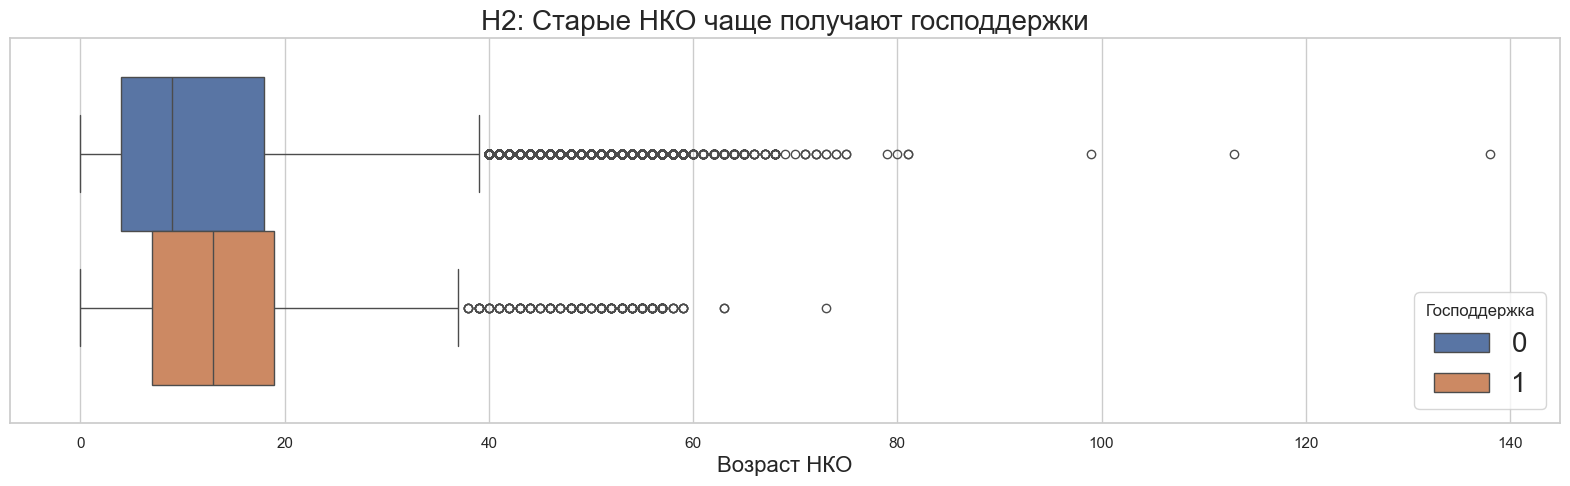

In [46]:
# Boxplot с аннотацией результатов
fig = plt.figure(figsize=(20, 5))

sns.boxplot(data=df, hue='has_support', x='age')
plt.title('H2: Старые НКО чаще получают господдержки', fontsize=20);
plt.xlabel('Возраст НКО', fontsize=16)
plt.legend(title='Господдержка', fontsize=20);

#### Влияет ли вид деятельности (ОКВЭД) на вероятность получения господдежки?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Вид деятельности НКО (ОКВЭД) не влияет на вероятность получения государственной поддержки. Распределение грантов/поддержки равномерно между разными направлениями деятельности.

*Альтернативная гипотеза*  ($H_1$): Вероятность получения государственной поддержки зависит от вида деятельности НКО (ОКВЭД). Некоторые направления финансируются чаще, другие — реже.

Для категориальных несвязынных выборок стоит использовать Хи-квадрат

In [47]:
# Создаем таблицу сопряженности
contingency_table = pd.crosstab(df['mainOkved.name'], df['has_support'])

# Применяем критерий Хи-квадрат
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

decision_hypothesis(p)

# Cramér's V — размер эффекта для хи-квадрат
n = contingency_table.sum().sum()
phi = np.sqrt(chi2 / n)
print(f"Cramér's V = {phi:.3f}")

  p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.
Cramér's V = 0.307


Отвергаем $H_0$: категории НЕ независимы — есть сильная связь. ОКВЭД оказывает средне-сильное влияние на вероятность господдержки (V=0.307)

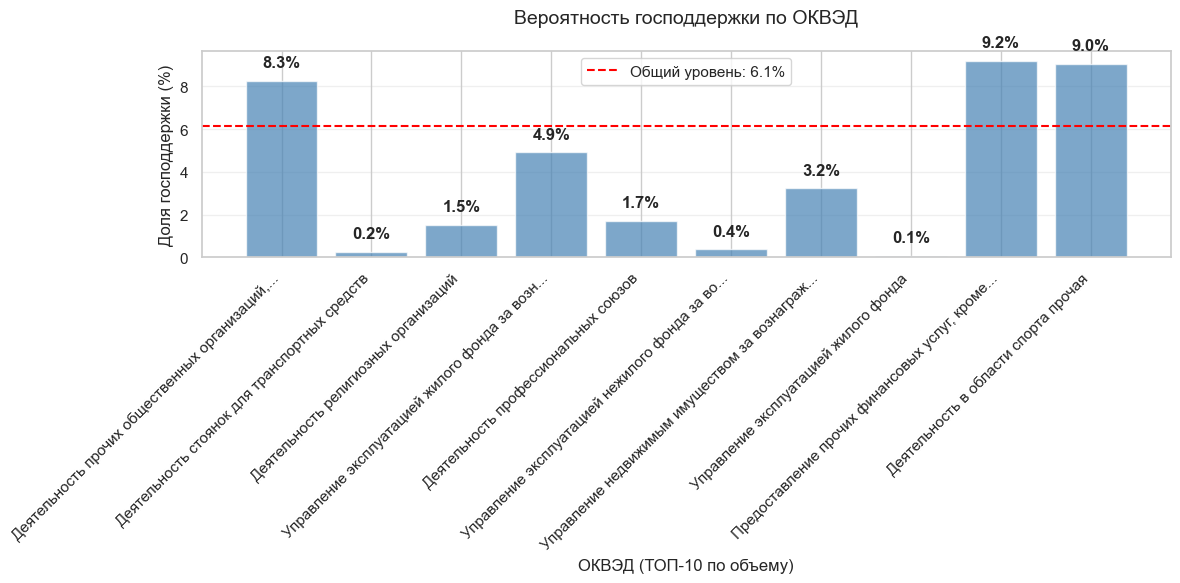

In [48]:
plt.figure(figsize=(12, 6))

# ТОП-10 по общему числу НКО
top10_okved = contingency_table.sum(axis=1).nlargest(10).index
top10_table = contingency_table.loc[top10_okved]

# Доли господдержки (%)
support_rates = top10_table.iloc[:, 1] / top10_table.sum(axis=1)  # has_support=1 / total

# Столбчатая диаграмма
bars = plt.bar(range(10), support_rates.values * 100, color='steelblue', alpha=0.7)
plt.axhline(y=df['has_support'].mean() * 100, color='red', ls='--', 
            label=f'Общий уровень: {df["has_support"].mean():.1%}')

# Подписи значений НА барах
for i, (bar, rate) in enumerate(zip(bars, support_rates)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

# Оформление
plt.xticks(range(10), [x[:45] + '...' if len(x) > 45 else x for x in top10_okved], 
           rotation=45, ha='right')
plt.ylabel('Доля господдержки (%)', fontsize=12)
plt.xlabel('ОКВЭД (ТОП-10 по объему)', fontsize=12)
plt.title(f'Вероятность господдержки по ОКВЭД', 
          fontsize=14, pad=20)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Государственная поддержка наиболее вероятна в сферах спорта (9,2%), общественных организаций (9,0%) и стоянок для транспорта (8,3%), значительно превышая средний уровень (6,1%). Умеренная поддержка — в управлении жилым и нежилым фондом (4,9–3,2%). Минимальная поддержка приходится на финансовый сектор (0,1%) и религиозные организации (0,2%). Распределение неравномерное, что отражает селективный характер господдержк

#### Различаются ли медианные значения возраста между группами, определёнными по статусу в Минюсте?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$):  Медианы возраста НКО не различаются между группами по minjustStatus (нет значимой разницы).

*Альтернативная гипотеза*  ($H_1$): Хотя бы в одной группе медиана возраста значимо отличается от других (есть различия).

Для трех независимых групп стоит применить критерий Краскела — Уоллиса

In [49]:
# Получаем уникальные значения статуса
status_groups = df['minjustStatus'].unique()

# Создаём списки значений age для каждой группы
age_groups = [df[df['minjustStatus'] == status]['age'] for status in status_groups]

h_stat, p_value = stats.kruskal(*age_groups)

print(f"Статистика теста (H): {h_stat:.2f}")
decision_hypothesis(p_value)


Статистика теста (H): 450.94
  p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.


Статусы в Минюсте связаны с разным «средним» возрастом. Высокая статистика теста (H = 450.94) указывает на очень сильное различие между группами — это не случайная флуктуация, а системная закономерность в данных.

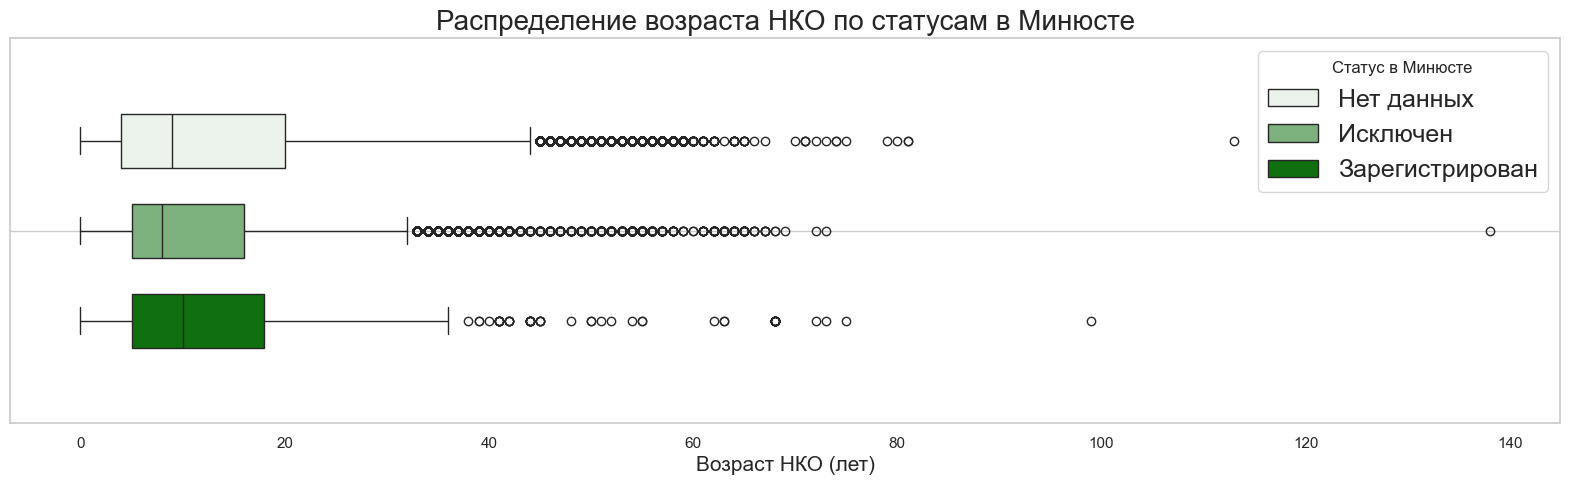

In [50]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=df, hue='minjustStatus', x='age', palette='light:green', width=0.7,  gap=0.4)
plt.title('Распределение возраста НКО по статусам в Минюсте', size=20)
plt.xlabel('Возраст НКО (лет)', fontsize=15)

plt.legend(['Нет данных','Исключен','Зарегистрирован'], 
           title='Статус в Минюсте', 
           fontsize=18) 

plt.grid();


- Большинство НКО независимо от статуса относительно «молодые» (возраст до 20 лет).
- Выбросы (НКО старше 40–50 лет) встречаются во всех категориях, но наиболее выражены у «Зарегистрированных» и «Нет данных».
- Статус «Исключён» характеризуется наименьшим средним возрастом, что может указывать на более короткий «жизненный цикл» таких организаций.

#### Влияет ли фактор наличия региональной поддержки на получение господдержки?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$):  Наличие общей поддержки не связано с наличием региональной поддержки (переменные независимы)

*Альтернативная гипотеза*  ($H_1$): : Наличие общей поддержки связано с наличием региональной поддержки (переменные зависимы)

Поскольку обе переменные качественные (бинарные), подойдёт хи-квадрат тест (χ²) для проверки независимости двух категориальных переменных.

In [51]:
# Таблица сопряжённости
contingency_table = pd.crosstab(df['has_support'], df['hasRegionalSupport'])

# Хи-квадрат тест
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"χ² статистика: {chi2}")
print(f"Степени свободы: {dof}")
print(f"Ожидаемые частоты:\n{expected}")
print('-'*40)
decision_hypothesis(p)


χ² статистика: 24477.94418149786
Степени свободы: 1
Ожидаемые частоты:
[[498974.26989188  10279.73010812]
 [ 32631.73010812    672.26989188]]
----------------------------------------
  p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.


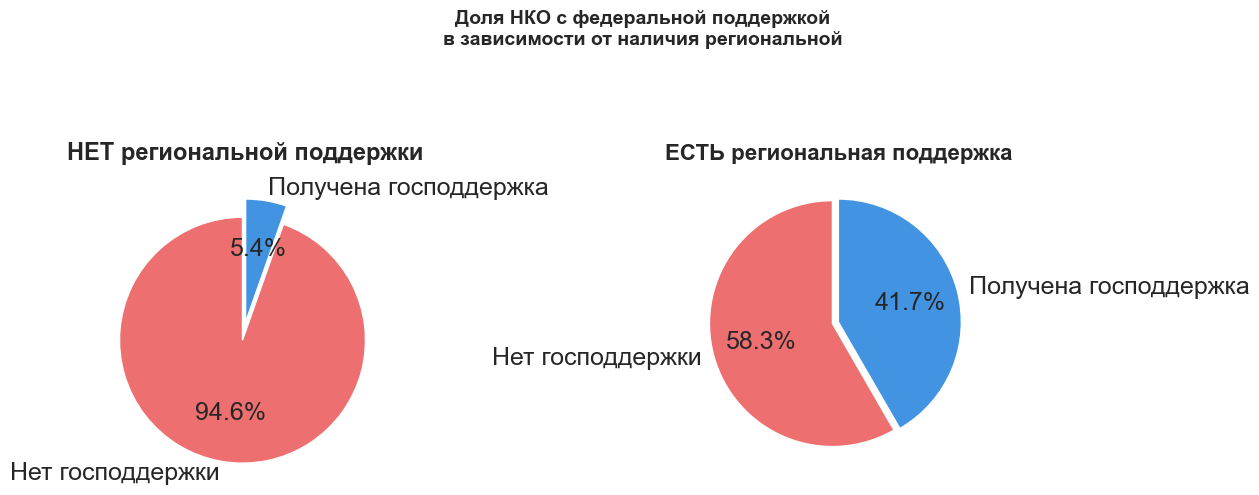

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Данные
total_no_regional = contingency_table[0].sum() 
total_has_regional = contingency_table[1].sum()

# 1. НЕТ региональной поддержки
values1 = [contingency_table.loc[0, 0], contingency_table.loc[1, 0]]
labels1 = ['Нет господдержки', 'Получена господдержка']
colors1 = ["#ed6f6f", "#4393e3"]
axes[0].pie(
    values1,
    labels=labels1,
    colors=colors1,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.15, 0),
    textprops={'fontsize': 18}
)
axes[0].set_title('НЕТ региональной поддержки',
                  fontweight='bold',
                  fontsize=17)

# 2. ЕСТЬ региональная поддержка
values2 = [contingency_table.loc[0, 1], contingency_table.loc[1, 1]]
labels2 = ['Нет господдержки', 'Получена господдержка']
colors2 = ["#ed6f6f", "#4393e3"]
axes[1].pie(
    values2,
    labels=labels2,
    colors=colors2,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0),
    textprops={'fontsize': 18}
)
axes[1].set_title('ЕСТЬ региональная поддержка',
                  fontweight='bold',
                  fontsize=16)

plt.suptitle('Доля НКО с федеральной поддержкой\nв зависимости от наличия региональной', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()

Значение χ² (4730.58) крайне велико. Это указывает на значительное расхождение между наблюдаемыми и ожидаемыми частотами — то есть распределение поддержки не случайно, а подчиняется определённой закономерности.

Cвязь между *has_support* и *hasRegionalSupport* статистически значима и сильна. Это ключевой индикатор координации между уровнями поддержки НКО.

# Проектирование новых признаков

В признаке *years_income* содержится утечка данных о таргете. Очевидно, что такой признак приедется удалить. Перед этим посморим, может ли он быть полезен для дальшейшего анализа.

<Axes: xlabel='years_income', ylabel='Count'>

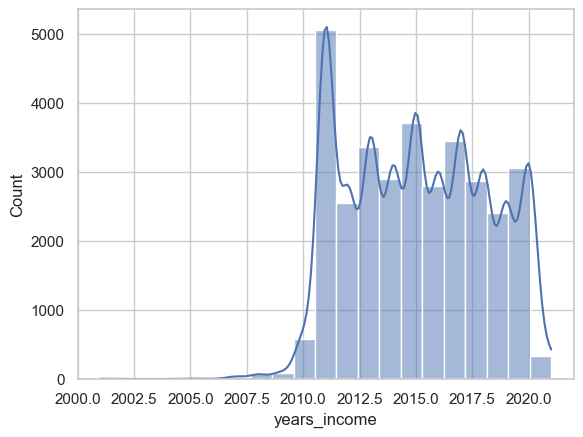

In [81]:
# Посмотрим в какие года чаще всего оказывалась господдержка
supported_nko = df.query('has_support == 1')

sns.histplot(supported_nko, x='years_income', bins=21, kde=True)

In [87]:
supported_nko['age_income'] = supported_nko['years_income'] - supported_nko['registration_year']

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542558 entries, 0 to 542557
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   regionName          542558 non-null  object
 1   minjustForm         542558 non-null  object
 2   minjustStatus       542558 non-null  int64 
 3   ogrn                542558 non-null  object
 4   is_liquidated       542558 non-null  int32 
 5   regionCode          542558 non-null  int32 
 6   hasRegionalSupport  542558 non-null  int32 
 7   opf.name            542558 non-null  object
 8   mainOkved.name      542558 non-null  object
 9   mainOkved.code      542558 non-null  object
 10  registration_year   542558 non-null  int32 
 11  liquidation_year    542558 non-null  int32 
 12  years_income        542558 non-null  int32 
 13  is_new_okved        542558 non-null  int32 
 14  admin_group         542558 non-null  object
 15  has_support         542558 non-null  int32 
 16  ag

In [120]:
supported_nko['age_group'] = pd.cut(
    supported_nko.age,
    [-100, 1, 5, 10, 15, 20, 25, 30, 200],
    labels = ['до 1', 'до 5', 'до 10', 'до 15', 'до 20', 'до 25', 'до 30', 'остальные']
)

<Axes: xlabel='age_group', ylabel='count'>

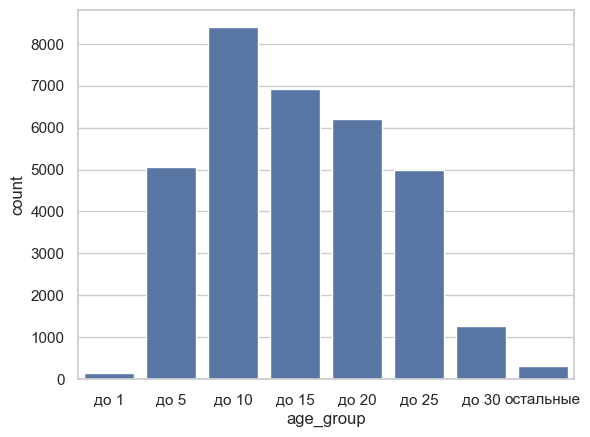

In [121]:
sns.countplot(supported_nko, x='age_group')

In [122]:
# Признак "молодая организация" (первые 3 года)
df['is_young'] = (df['age'] <= 3).astype(int)

# Признак "пиковый возраст" (1-2 года - самый высокий шанс)
df['is_peak_age'] = (df['age'].between(1, 2)).astype(int)

# Признак "зрелая организация" (после 15 лет - шанс резко падает)
df['is_very_old'] = (df['age'] >= 16).astype(int)

# Молодая НКО + региональная поддержка
df['young_and_regional'] = df['is_young'] * df['hasRegionalSupport']

# Молодая НКО + новый ОКВЭД (активно меняются под гранты)
df['young_and_new_okved'] = df['is_young'] * df['is_new_okved']

# Возрастная группа + регион (для учета региональных особенностей)
df['age_group_region'] = df['age_group'].astype(str) + '_' + df['regionCode'].astype(str)

<Axes: >

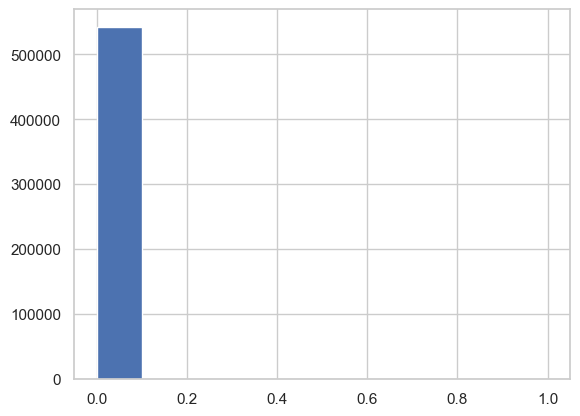

In [125]:
df['young_and_regional'].hist()

<Axes: xlabel='age_income', ylabel='Count'>

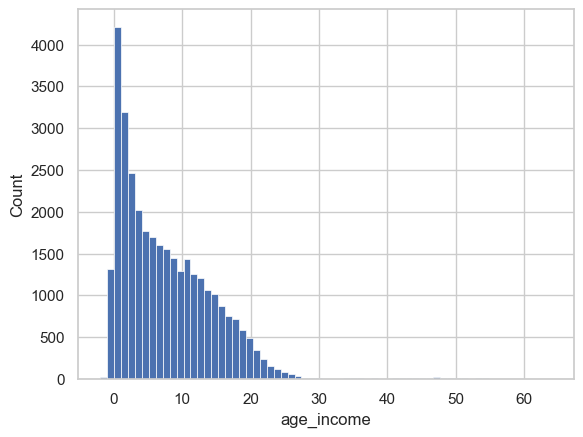

In [210]:
sns.histplot(supported_nko['age_income'], palette='black', bins=65, alpha=1)
#sns.histplot(df, x='age', palette='dark:brown', bins=70, alpha=0.3)


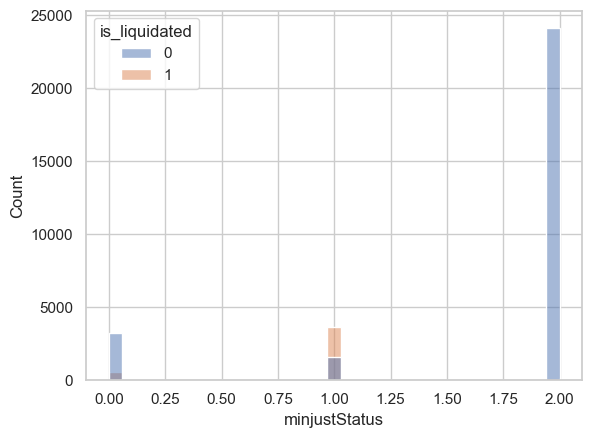

In [164]:
sns.histplot(supported_nko, hue='is_liquidated', x='minjustStatus');

#supported_nko.groupby(['is_liquidated'])['minjustStatus'].first()

In [165]:
df.columns

Index(['regionName', 'minjustForm', 'minjustStatus', 'ogrn', 'is_liquidated',
       'regionCode', 'hasRegionalSupport', 'opf.name', 'mainOkved.name',
       'mainOkved.code', 'registration_year', 'liquidation_year',
       'years_income', 'is_new_okved', 'admin_group', 'has_support', 'age',
       'age_group', 'is_young', 'is_peak_age', 'is_very_old',
       'young_and_regional', 'young_and_new_okved', 'age_group_region'],
      dtype='object')

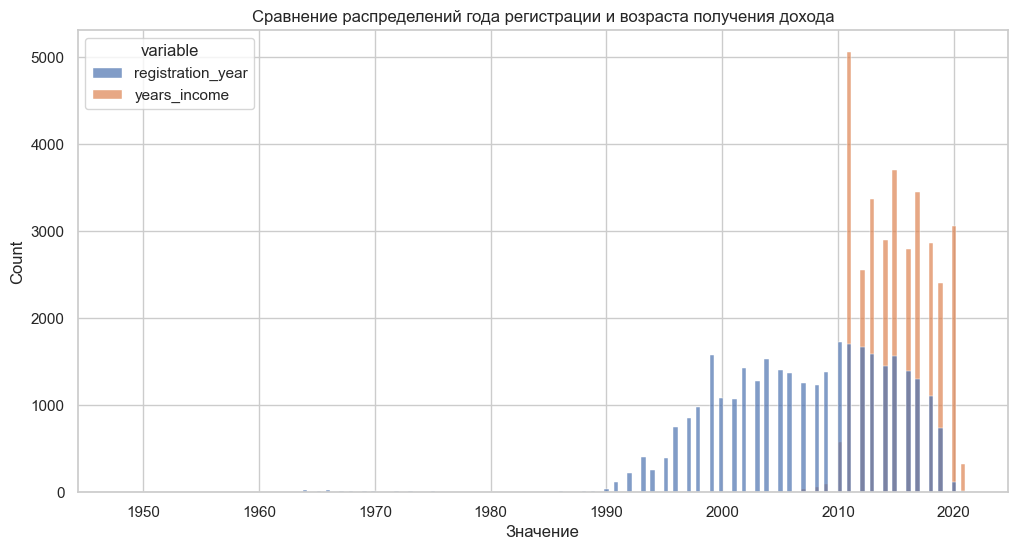

In [178]:
# Создаем DataFrame в длинном формате
df_melted = supported_nko.melt(
    value_vars=['registration_year', 'years_income'], 
    var_name='variable', 
    value_name='value'
)

# Строим гистограммы рядом
plt.figure(figsize=(12, 6))
sns.histplot(data=df_melted, x='value', hue='variable', alpha=0.7)
plt.title('Сравнение распределений года регистрации и возраста получения дохода')
plt.xlabel('Значение')
plt.show()

In [259]:
supported_nko['years_income'].value_counts()

years_income
2011    5060
2015    3710
2017    3454
2013    3372
2020    3062
2014    2900
2018    2870
2016    2799
2012    2553
2019    2408
2010     576
2021     330
2009      90
2008      66
2007      36
2005       6
2006       4
2001       4
2002       2
2003       1
2004       1
Name: count, dtype: int64

In [215]:
df[df['registration_year'] < 2010]['has_support'].value_counts(normalize=True)

has_support
0    0.941233
1    0.058767
Name: proportion, dtype: float64

In [261]:
is_peak_period = (df['registration_year'] >= 1998) & (df['registration_year'] <= 2003)
df[df['years_income'] == 2011]['registration_year'].value_counts()

registration_year
1999    375
2004    365
2002    357
2005    351
2010    326
2003    313
2006    310
2007    300
2008    296
2001    280
2000    269
2009    268
1998    268
1997    210
1996    198
1993    140
2011    113
1994     90
1995     84
1992     76
1991     27
1964      8
1990      5
1970      4
1968      3
1976      2
1967      2
1969      2
1984      2
1977      2
1989      2
1973      2
1988      2
1982      1
1987      1
1966      1
1979      1
1985      1
1971      1
1962      1
1986      1
Name: count, dtype: int64

In [257]:
for i in range(1995, 2018):
    for j in range(i+5, 2023):
        mask = (df['registration_year'] >= i) & (df['registration_year'] <= j)
        value = 100 - (df[mask]['has_support'].value_counts(normalize=True)*100).iloc[0]
        if value > 7:
            print(f'{i=}, {j=}, {value=:.3f}')
            break


i=1995, j=2002, value=7.217
i=1996, j=2001, value=7.136
i=1997, j=2002, value=7.547
i=1998, j=2003, value=7.685
i=1999, j=2004, value=7.343
i=2000, j=2005, value=7.049
i=2009, j=2014, value=7.151
i=2010, j=2015, value=7.604
i=2011, j=2016, value=7.580
i=2012, j=2017, value=7.395
i=2013, j=2018, value=7.259


In [ ]:
(df[mask]['has_support'].value_counts(normalize=True)*100).iloc[0]

TypeError: 'property' object is not subscriptable